In [223]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import ResNet50, Xception, InceptionV3, VGG16, VGG19, MobileNetV2
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adamax, Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [114]:
train_dir = './Training'
test_dir = './Testing'

## EDA

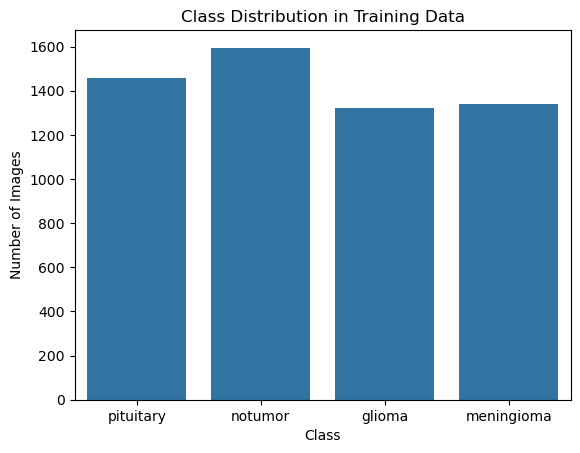

In [115]:
import os

# List the class names (folders in train_dir)
class_names = os.listdir(train_dir)

# Count the number of images in each class
class_counts = {}
for class_name in class_names:
    class_folder = os.path.join(train_dir, class_name)
    class_counts[class_name] = len(os.listdir(class_folder))

# Visualize the class distribution
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.title('Class Distribution in Training Data')
plt.ylabel('Number of Images')
plt.xlabel('Class')
plt.show()

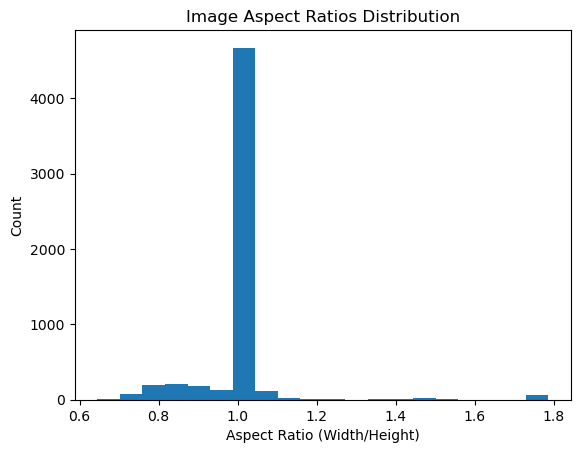

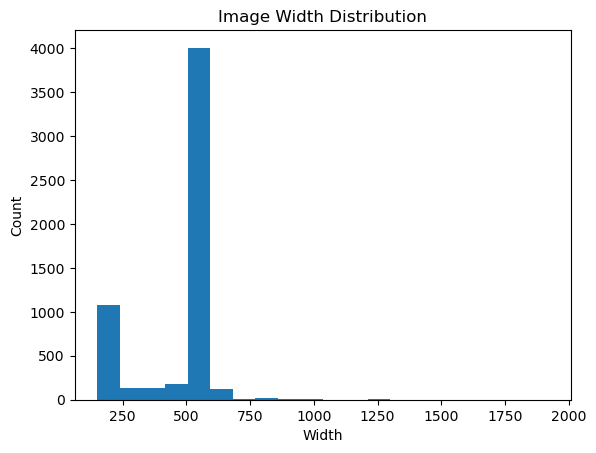

In [117]:
from PIL import Image

image_dims = []
for class_name in class_names:
    class_folder = os.path.join(train_dir, class_name)
    for img_name in os.listdir(class_folder):
        img_path = os.path.join(class_folder, img_name)
        img = Image.open(img_path)
        image_dims.append(img.size)

image_dims = np.array(image_dims)

aspect_ratios = image_dims[:, 0] / image_dims[:, 1]
plt.hist(aspect_ratios, bins=20)
plt.title('Image Aspect Ratios Distribution')
plt.xlabel('Aspect Ratio (Width/Height)')
plt.ylabel('Count')
plt.show()

plt.hist(image_dims[:, 0], bins=20)
plt.title('Image Width Distribution')
plt.xlabel('Width')
plt.ylabel('Count')
plt.show()

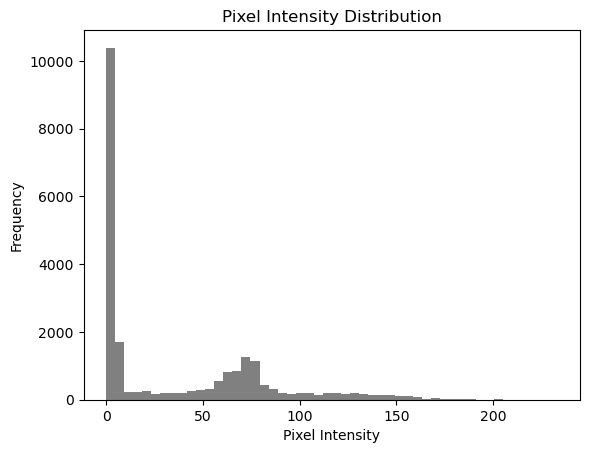

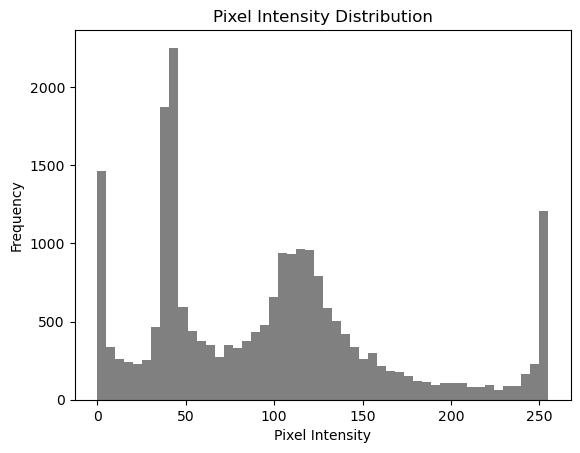

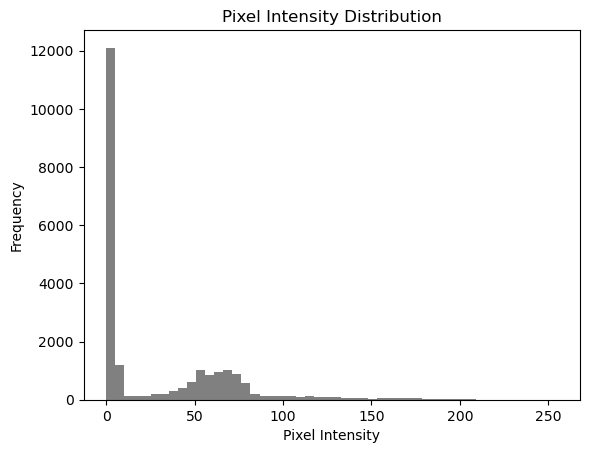

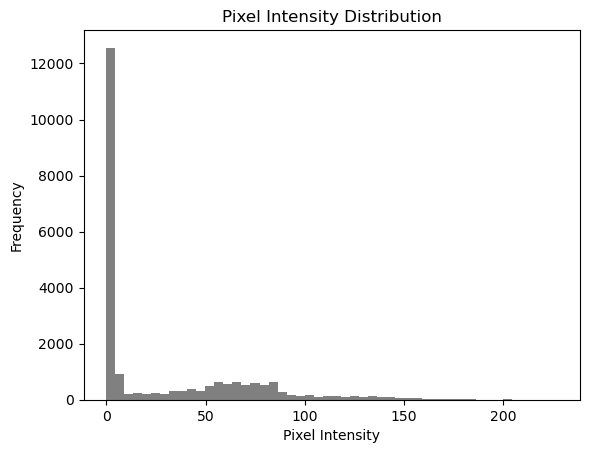

In [118]:
def plot_image_histogram(img_path):
    img = load_img(img_path, target_size=(150, 150), color_mode='grayscale')
    img_array = img_to_array(img).flatten()
    
    plt.hist(img_array, bins=50, color='gray')
    plt.title('Pixel Intensity Distribution')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.show()

# Plot the pixel intensity histogram for one sample image from each class
for class_name in class_names:
    class_folder = os.path.join(train_dir, class_name)
    img_path = os.path.join(class_folder, os.listdir(class_folder)[0])
    plot_image_histogram(img_path)

In [121]:
# Use ImageDataGenerator to import images from the class folders
# Apply data augmentation to the training dataset
train_datagen = ImageDataGenerator(
    rescale=1./255,
    #rotation_range=10,
    #width_shift_range=0.1,
    #height_shift_range=0.1,
    #zoom_range=0.1,
    #horizontal_flip=True,
    # fill_mode='nearest',
    validation_split=0.15
)

image_size = 150
test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(image_size, image_size),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True,
)

validation_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(image_size, image_size),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(image_size, image_size),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
)


Found 4857 images belonging to 4 classes.
Found 855 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [128]:
images, labels = next(validation_data)


print(np.argmax(labels, axis=1))
train_data.classes

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


array([0, 0, 0, ..., 3, 3, 3], dtype=int32)

In [129]:
train_data.class_indices

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [130]:
test_data.class_indices

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [132]:
# Class counts seem fairly balanced
class_count = Counter(train_data.classes)
class_count

Counter({2: 1356, 3: 1239, 1: 1139, 0: 1123})

In [133]:
test_count = Counter(test_data.classes)
test_count

Counter({2: 405, 1: 306, 0: 300, 3: 300})

In [134]:
validation_count = Counter(validation_data.classes)
validation_count

Counter({2: 239, 3: 218, 1: 200, 0: 198})

In [135]:
test_data.samples

1311

In [136]:
train_data.samples

4857

In [137]:
validation_data.samples

855

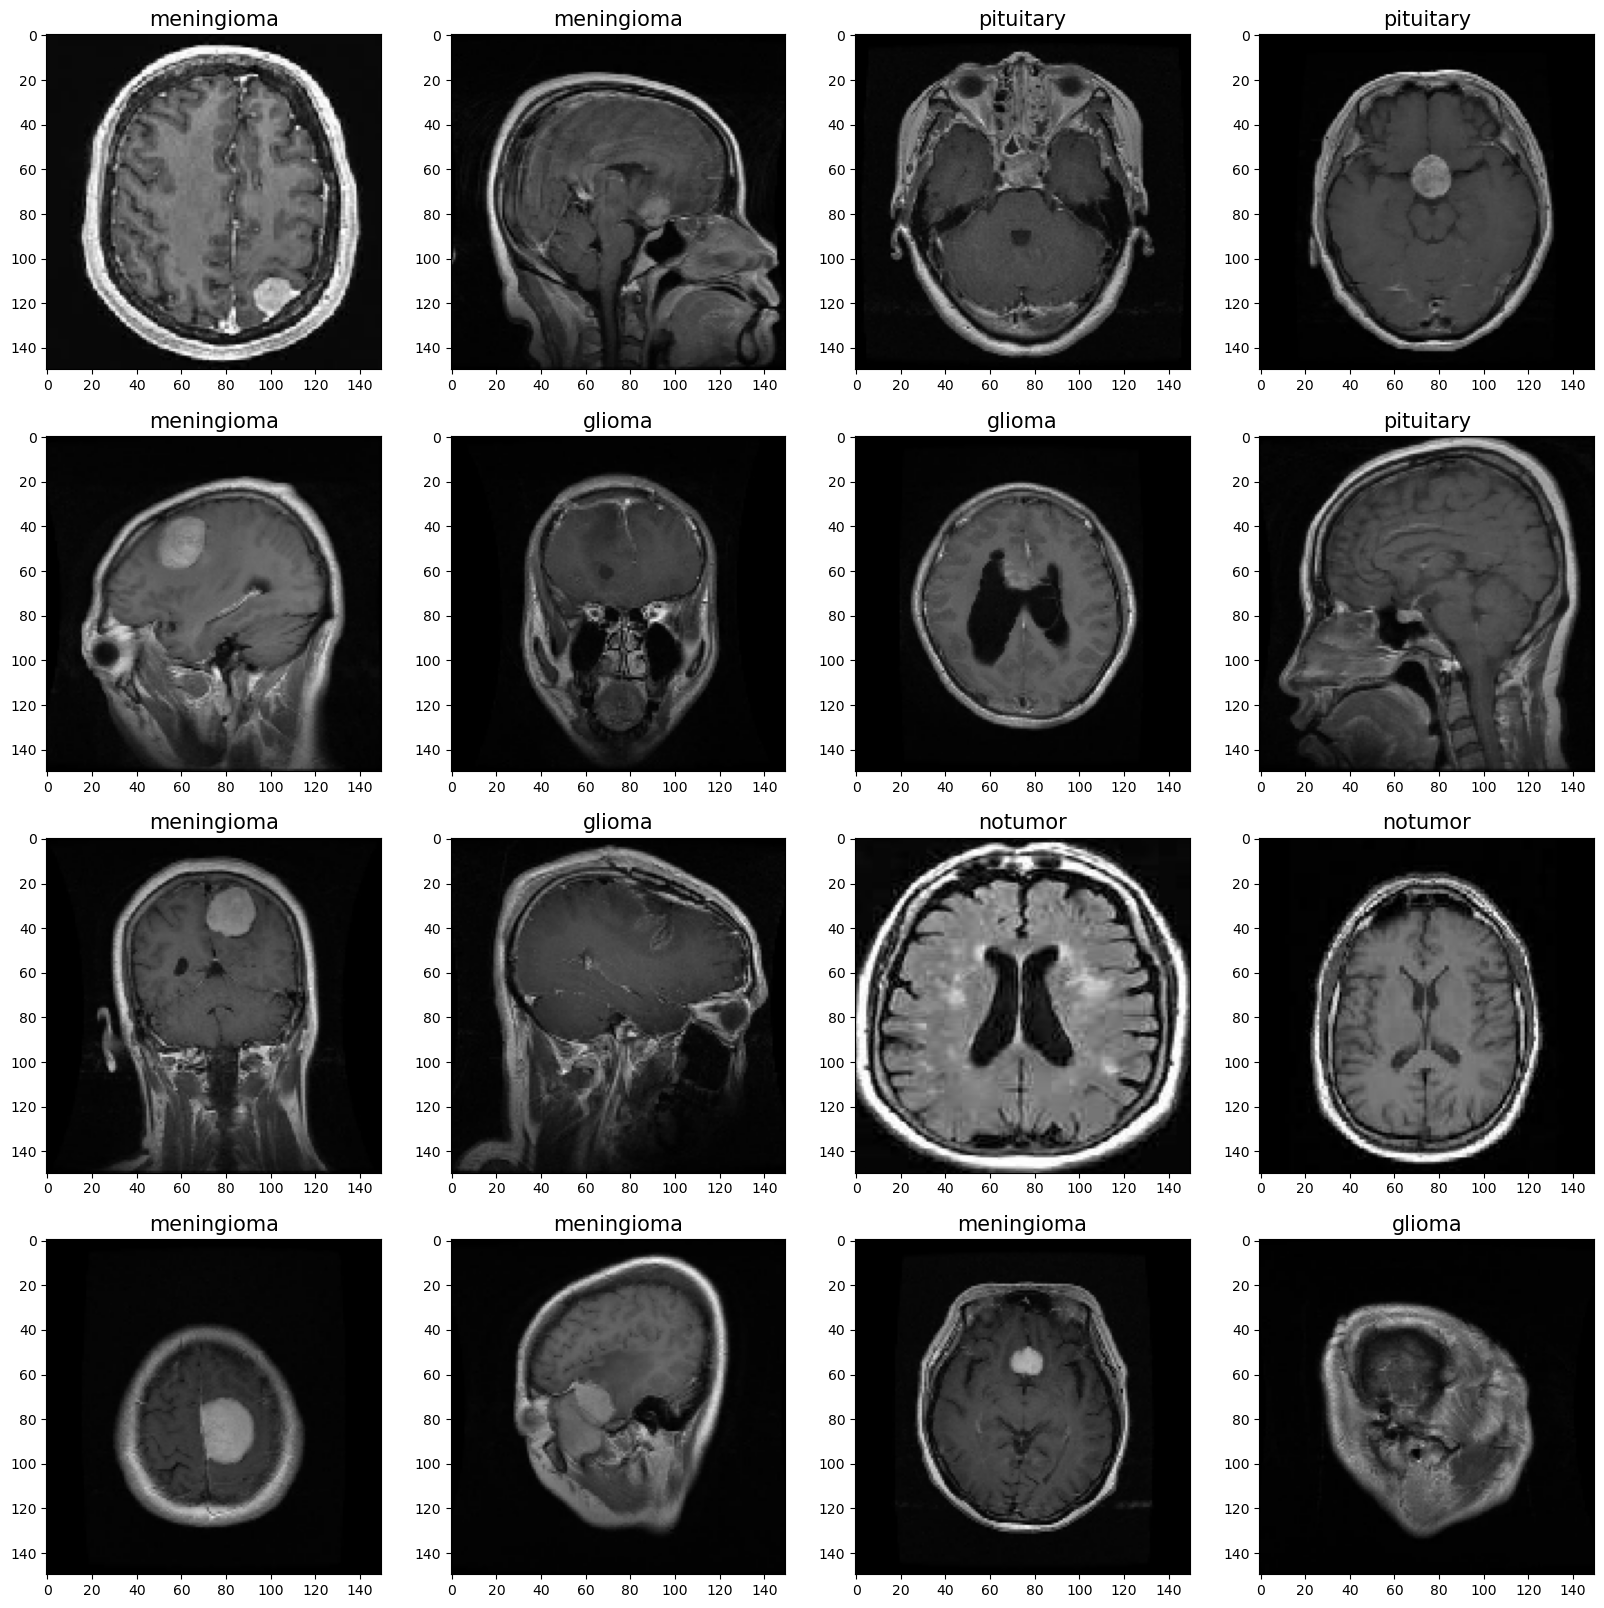

In [138]:
class_dict = train_data.class_indices
classes = list(class_dict.keys())
images, labels = next(train_data)

plt.figure(figsize=(20, 20))

for i, (image, label) in enumerate(zip(images, labels)):
    if i >= 16:
        break
    plt.subplot(4, 4, i + 1)
    plt.imshow(image)
    class_name = classes[np.argmax(label)]
    plt.title(class_name, color='k', fontsize=15)

plt.show()

In [140]:
images[0].shape

(150, 150, 3)

## Model 1: ANN model

In [141]:
num_hidden1 = 256
num_hidden2 = 128
num_hidden3 = 64
num_hidden4 = 32
num_output = 4
modelANN = Sequential([
    Flatten(input_shape=(image_size, image_size, 3)),
    Dense(num_hidden1, activation = 'relu'),
    Dense(num_hidden2, activation = 'relu'),
    Dense(num_hidden3, activation = 'relu'),
    Dense(num_hidden4, activation = 'relu'),
    Dense(num_output, activation = 'softmax')
])

In [142]:
modelANN.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [143]:
epochs = 15
history = modelANN.fit(train_data, validation_data=validation_data, epochs=epochs)

Epoch 1/15


2024-10-10 15:21:50.399311: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


152/152 [==============================] - ETA: 0s - loss: 1.3275 - accuracy: 0.5893

2024-10-10 15:21:56.095697: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


152/152 [==============================] - 7s 45ms/step - loss: 1.3275 - accuracy: 0.5893 - val_loss: 1.5137 - val_accuracy: 0.4924
Epoch 2/15
152/152 [==============================] - 6s 39ms/step - loss: 0.6345 - accuracy: 0.7632 - val_loss: 1.1189 - val_accuracy: 0.6538
Epoch 3/15
152/152 [==============================] - 6s 39ms/step - loss: 0.5300 - accuracy: 0.8017 - val_loss: 1.0318 - val_accuracy: 0.6082
Epoch 4/15
152/152 [==============================] - 6s 38ms/step - loss: 0.3987 - accuracy: 0.8561 - val_loss: 1.0456 - val_accuracy: 0.6994
Epoch 5/15
152/152 [==============================] - 6s 38ms/step - loss: 0.3759 - accuracy: 0.8618 - val_loss: 1.0677 - val_accuracy: 0.6678
Epoch 6/15
152/152 [==============================] - 6s 39ms/step - loss: 0.3145 - accuracy: 0.8806 - val_loss: 1.1205 - val_accuracy: 0.6912
Epoch 7/15
152/152 [==============================] - 6s 40ms/step - loss: 0.2827 - accuracy: 0.9012 - val_loss: 1.2433 - val_accuracy: 0.6784
Epoch 8/15

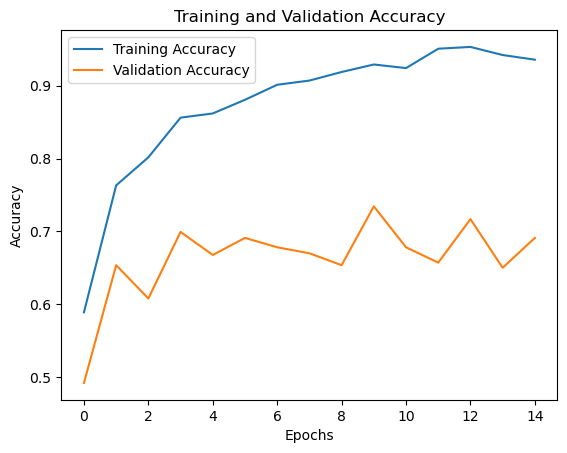

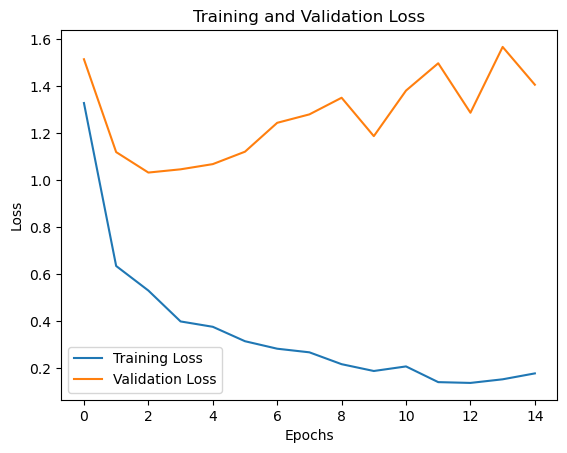

In [144]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [145]:
#use the model on test data and evaluate the performance
test_loss, test_accuracy = modelANN.evaluate(test_data)
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')

 4/41 [=>............................] - ETA: 1s - loss: 1.5073 - accuracy: 0.5156

2024-10-10 15:23:44.078317: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


41/41 [==============================] - 1s 29ms/step - loss: 0.6128 - accuracy: 0.8276
Test loss: 0.6127930879592896
Test accuracy: 0.8276125192642212


 3/41 [=>............................] - ETA: 1s

2024-10-10 15:24:04.390220: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


41/41 [==============================] - 1s 26ms/step


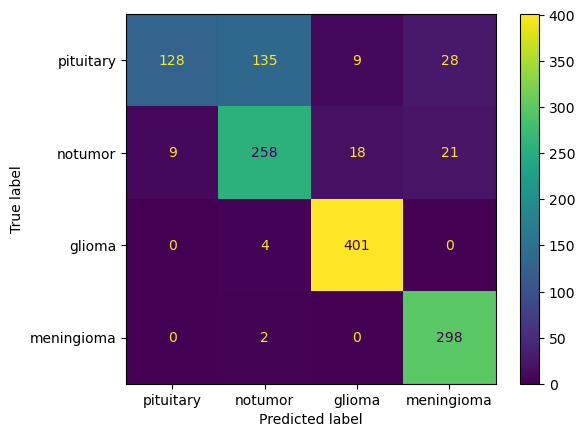

In [146]:
# display the confusion matrix
predictions = modelANN.predict(test_data)
y_pred = np.argmax(predictions, axis=1)
y_true = test_data.classes
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot()

Regular ANN model has OK performance, but it's having trouble predicting pituitary stage. This is expected because brain tumor development is spatial related.

## Model 2: CNN Model

In [287]:
# Model architecture
modelCNN = Sequential([
    Conv2D(32, (4, 4), activation='relu', input_shape=(image_size, image_size, 3)),
    MaxPooling2D(3, 3),
    Conv2D(64, (4, 4), activation='relu'),
    MaxPooling2D(3, 3),
    Conv2D(128, (4, 4), activation='relu'),
    MaxPooling2D(3, 3),
    Conv2D(256, (4, 4), activation='relu'),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

modelCNN.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_61 (Conv2D)          (None, 147, 147, 32)      1568      
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 49, 49, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_62 (Conv2D)          (None, 46, 46, 64)        32832     
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 15, 15, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_63 (Conv2D)          (None, 12, 12, 128)       131200    
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 4, 4, 128)      

In [288]:
modelCNN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [289]:
model_es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=True, restore_best_weights=True)
checkpoint = ModelCheckpoint('customCNNModel.h5', save_best_only=True, monitor="val_accuracy", mode="auto")
model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=True)

In [290]:
epochs = 20
CNNhistory = modelCNN.fit(
    train_data,
    epochs=epochs,
    validation_data=test_data,
    callbacks=[model_es, model_rlr, checkpoint]
)

Epoch 1/20


2024-10-10 17:40:29.441497: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


152/152 [==============================] - ETA: 0s - loss: 0.8020 - accuracy: 0.6317

2024-10-10 17:40:45.095514: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


152/152 [==============================] - 17s 112ms/step - loss: 0.8020 - accuracy: 0.6317 - val_loss: 0.5952 - val_accuracy: 0.7407 - lr: 0.0010
Epoch 2/20
152/152 [==============================] - 17s 111ms/step - loss: 0.4027 - accuracy: 0.8411 - val_loss: 0.4510 - val_accuracy: 0.8223 - lr: 0.0010
Epoch 3/20
152/152 [==============================] - 17s 110ms/step - loss: 0.2831 - accuracy: 0.8942 - val_loss: 0.4364 - val_accuracy: 0.8413 - lr: 0.0010
Epoch 4/20
152/152 [==============================] - 17s 112ms/step - loss: 0.2076 - accuracy: 0.9259 - val_loss: 0.3470 - val_accuracy: 0.8566 - lr: 0.0010
Epoch 5/20
152/152 [==============================] - 17s 112ms/step - loss: 0.1749 - accuracy: 0.9354 - val_loss: 0.3358 - val_accuracy: 0.8764 - lr: 0.0010
Epoch 6/20
152/152 [==============================] - 17s 110ms/step - loss: 0.1156 - accuracy: 0.9561 - val_loss: 0.3188 - val_accuracy: 0.9001 - lr: 0.0010
Epoch 7/20
152/152 [==============================] - 17s 111ms

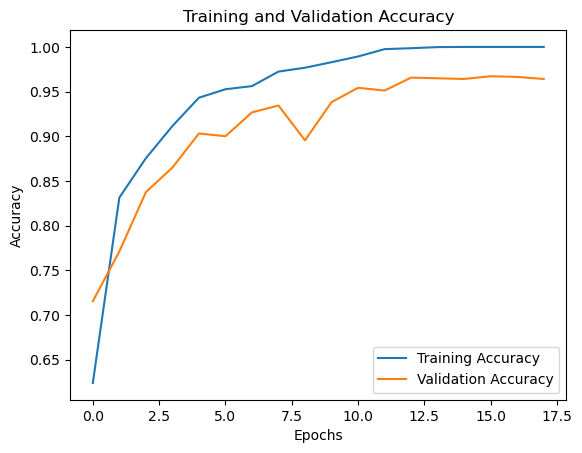

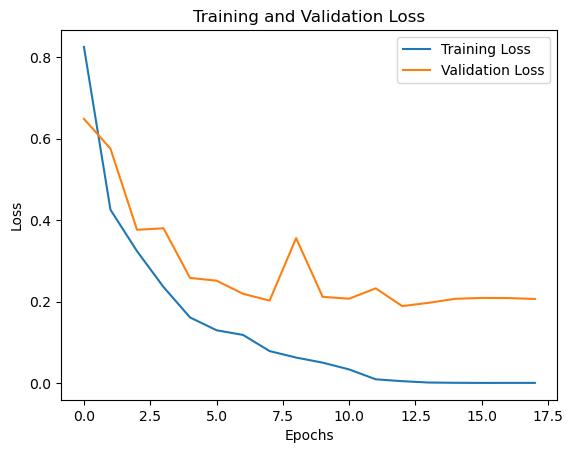

In [155]:
# Plot the training and validation accuracy
plt.plot(CNNhistory.history['accuracy'], label='Training Accuracy')
plt.plot(CNNhistory.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the training and validation loss
plt.plot(CNNhistory.history['loss'], label='Training Loss')
plt.plot(CNNhistory.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [292]:
# modelCNN = load_model('customCNNModel.h5')
test_loss, test_acc = modelCNN.evaluate(test_data)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

 2/41 [>.............................] - ETA: 2s - loss: 0.2970 - accuracy: 0.9062

2024-10-10 17:44:51.272194: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


41/41 [==============================] - 1s 35ms/step - loss: 0.1806 - accuracy: 0.9527
Test accuracy: 0.952707827091217
Test loss: 0.1806134283542633


In [162]:
predictions = modelCNN.predict(test_data)
y_pred = np.argmax(predictions, axis=1)
y_true = test_data.classes

 2/41 [>.............................] - ETA: 2s

2024-10-10 15:39:38.715774: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


41/41 [==============================] - 2s 36ms/step


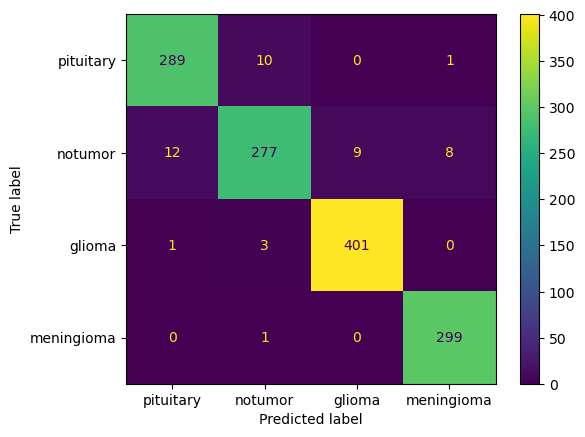

In [163]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot()

CNN model is able to diffrentiate well between no tumor class and pituitary class. It also achieves an whopping 96.5% accuracy rate in classifying unseen test images.

## Using Transfer Learning (Pretrained model)

### ResNet50 model

In [273]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

for layer in base_model.layers[:-10]:
    layer.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(4, activation='softmax')
])


model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 flatten_22 (Flatten)        (None, 51200)             0         
                                                                 
 dropout_24 (Dropout)        (None, 51200)             0         
                                                                 
 dense_47 (Dense)            (None, 256)               13107456  
                                                                 
 dropout_25 (Dropout)        (None, 256)               0         
                                                                 
 dense_48 (Dense)            (None, 64)                16448     
                                                                 
 dropout_26 (Dropout)        (None, 64)              

In [274]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [275]:
checkpoint = ModelCheckpoint("ResNet50.h5", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, mode='auto', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=3, mode='auto', verbose=1)

In [276]:
history = model.fit(
    train_data,
    epochs=15,
    validation_data=validation_data,
    callbacks=[checkpoint, reduce_lr, early_stopping]
)

Epoch 1/15


2024-10-10 17:15:41.071279: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


152/152 [==============================] - ETA: 0s - loss: 1.2248 - accuracy: 0.5359

2024-10-10 17:16:42.165462: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_accuracy improved from -inf to 0.31696, saving model to ResNet50.h5
152/152 [==============================] - 71s 458ms/step - loss: 1.2248 - accuracy: 0.5359 - val_loss: 1.3837 - val_accuracy: 0.3170 - lr: 0.0010
Epoch 2/15
152/152 [==============================] - ETA: 0s - loss: 0.8233 - accuracy: 0.6667
Epoch 2: val_accuracy improved from 0.31696 to 0.60585, saving model to ResNet50.h5
152/152 [==============================] - 69s 456ms/step - loss: 0.8233 - accuracy: 0.6667 - val_loss: 0.8823 - val_accuracy: 0.6058 - lr: 0.0010
Epoch 3/15
152/152 [==============================] - ETA: 0s - loss: 0.7330 - accuracy: 0.7171
Epoch 3: val_accuracy did not improve from 0.60585
152/152 [==============================] - 70s 458ms/step - loss: 0.7330 - accuracy: 0.7171 - val_loss: 1.0129 - val_accuracy: 0.5649 - lr: 0.0010
Epoch 4/15
152/152 [==============================] - ETA: 0s - loss: 0.6590 - accuracy: 0.7354
Epoch 4: val_accuracy improved from 0.60585 to 0.64327

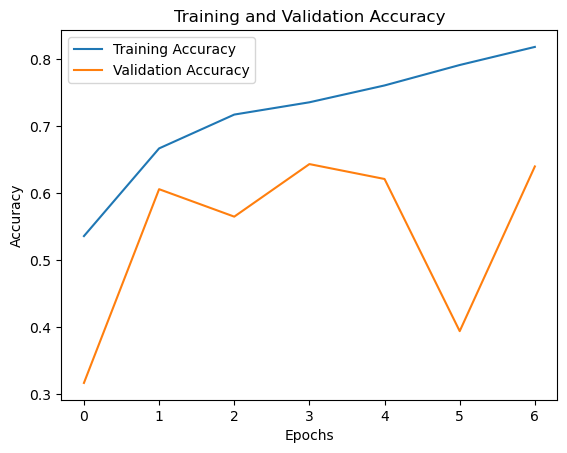

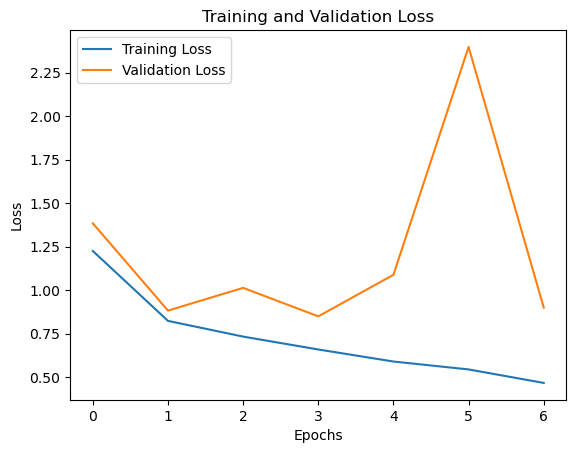

In [277]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

2024-10-10 17:23:56.638165: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


41/41 [==============================] - 14s 321ms/step


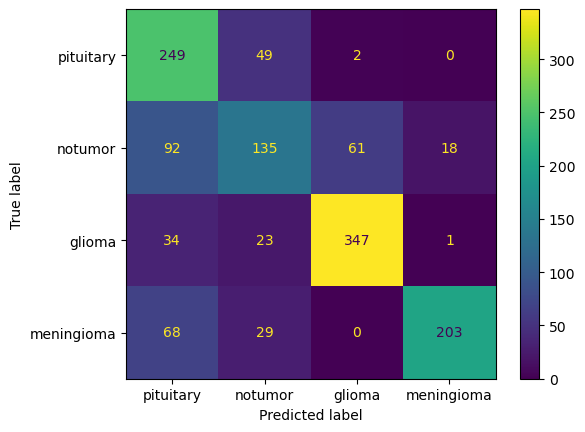

In [278]:
resnet50 = load_model('ResNet50.h5')
predictions = resnet50.predict(test_data)
y_pred = np.argmax(predictions, axis=1)
y_true = test_data.classes
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot()

In [271]:
test_loss, test_acc = resnet50.evaluate(test_data)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

2024-10-10 17:02:51.135856: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


41/41 [==============================] - 14s 328ms/step - loss: 0.4487 - accuracy: 0.8085
Test accuracy: 0.8085430860519409
Test loss: 0.4486875832080841


### Xception model

In [279]:
from tensorflow.keras.metrics import Precision, Recall
base_model = Xception(include_top= False, weights= "imagenet", input_shape= (image_size, image_size, 3), pooling= 'max')

for layer in base_model.layers[:-20]:
    layer.trainable = False
    
model = Sequential([
    base_model,
    Flatten(),
    Dropout(rate= 0.3),
    Dense(128, activation= 'relu'),
    Dropout(rate= 0.25),
    Dense(4, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy',
                        Precision(),
                        Recall()])

model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten_23 (Flatten)        (None, 2048)              0         
                                                                 
 dropout_27 (Dropout)        (None, 2048)              0         
                                                                 
 dense_50 (Dense)            (None, 128)               262272    
                                                                 
 dropout_28 (Dropout)        (None, 128)               0         
                                                                 
 dense_51 (Dense)            (None, 4)                 516       
                                                                 
Total params: 21,124,268
Trainable params: 7,589,164


In [280]:
checkpoint = ModelCheckpoint("Xception.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0.01, patience=3, mode='auto', verbose=1)

In [281]:
history = model.fit(train_data, validation_data= validation_data, epochs= 10, shuffle= False, callbacks= [checkpoint, early_stopping])

Epoch 1/10


2024-10-10 17:30:45.881350: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


152/152 [==============================] - ETA: 0s - loss: 0.3762 - accuracy: 0.8676 - precision_3: 0.8936 - recall_3: 0.8367

2024-10-10 17:31:53.710264: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_accuracy improved from -inf to 0.86550, saving model to Xception.h5
152/152 [==============================] - 76s 494ms/step - loss: 0.3762 - accuracy: 0.8676 - precision_3: 0.8936 - recall_3: 0.8367 - val_loss: 0.4032 - val_accuracy: 0.8655 - val_precision_3: 0.8717 - val_recall_3: 0.8585
Epoch 2/10
152/152 [==============================] - ETA: 0s - loss: 0.1156 - accuracy: 0.9582 - precision_3: 0.9618 - recall_3: 0.9551
Epoch 2: val_accuracy improved from 0.86550 to 0.92047, saving model to Xception.h5
152/152 [==============================] - 77s 508ms/step - loss: 0.1156 - accuracy: 0.9582 - precision_3: 0.9618 - recall_3: 0.9551 - val_loss: 0.2570 - val_accuracy: 0.9205 - val_precision_3: 0.9278 - val_recall_3: 0.9170
Epoch 3/10
152/152 [==============================] - ETA: 0s - loss: 0.0669 - accuracy: 0.9765 - precision_3: 0.9791 - recall_3: 0.9751
Epoch 3: val_accuracy improved from 0.92047 to 0.92398, saving model to Xception.h5
152/152 [===================

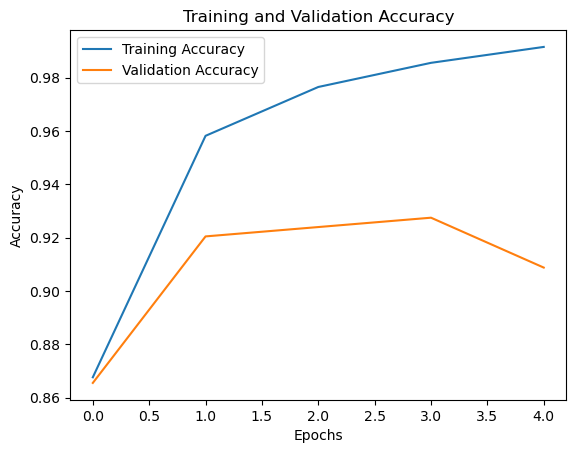

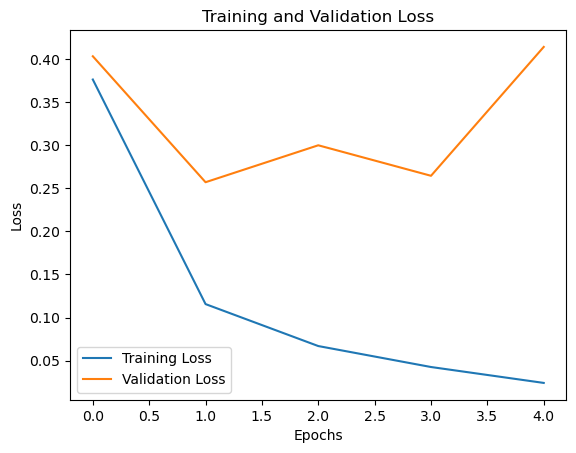

In [282]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

2024-10-10 16:59:45.735054: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


41/41 [==============================] - 12s 288ms/step


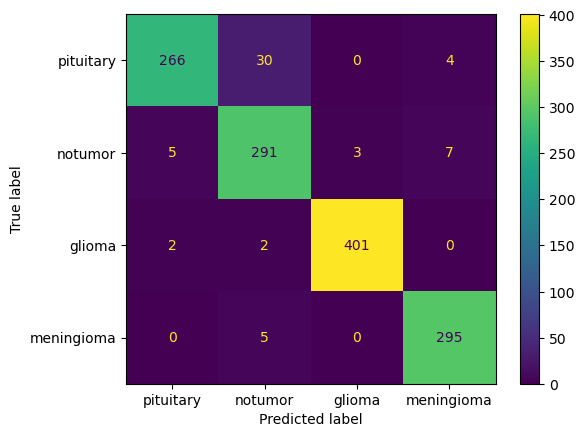

In [268]:
xception = load_model('Xception.h5')
predictions = xception.predict(test_data)
y_pred = np.argmax(predictions, axis=1)
y_true = test_data.classes
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot()

In [270]:
results = xception.evaluate(test_data)
test_loss, test_acc = results[0], results[1]
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

2024-10-10 17:02:09.263034: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


41/41 [==============================] - 12s 285ms/step - loss: 0.1506 - accuracy: 0.9558 - precision_2: 0.9565 - recall_2: 0.9550
Test accuracy: 0.9557589888572693
Test loss: 0.15062953531742096
